## Setup

### Install dependencies

In [2]:
! pip install transformers==4.31.0
! pip install datasets==2.13.1
! pip install pandas==2.0.3
! pip install numpy==1.25.1
! pip install matplotlib==3.7.2
! pip install seaborn==0.12.2
! pip install scikit-learn
! pip install transformers[torch]
! pip install accelerate -U

^C
ERROR: Operation cancelled by user


### Import dependencies

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datasets import Dataset, DatasetDict, load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding

## Data exploration

### Load data into dataframe

In [ ]:
df = pd.read_json("final-data.json")
df

,text,license
0,Attribution-NonCommercial-NoDerivs 2.0 Copyrig...,CC-BY-NC-ND-2.0
1,Attribution-NonCommercial-NoDerivs 2.0 Copyrig...,CC-BY-NC-ND-2.0
2,Attribution-NonCommercial-NoDerivs 2.0 Copyrig...,CC-BY-NC-ND-2.0
3,Attribution-NonCommercial-NoDerivs 2.0 Copyrig...,CC-BY-NC-ND-2.0
4,Attribution-NonCommercial-NoDerivs 2.0 Copyrig...,CC-BY-NC-ND-2.0
...,...,...
11213,APPLE PUBLIC SOURCE LICENSE\nVersion 2.0 - Au...,APSL-2.0
11214,APPLE PUBLIC SOURCE LICENSE\nVersion 2.0 - Au...,APSL-2.0
11215,APPLE PUBLIC SOURCE LICENSE\nVersion 2.0 - Au...,APSL-2.0
11216,APPLE PUBLIC SOURCE LICENSE\nVersion 2.0 - Au...,APSL-2.0


In [ ]:
df['text'] = df['text'].str.lower()
df

,text,license
0,attribution-noncommercial-noderivs 2.0 copyrig...,CC-BY-NC-ND-2.0
1,attribution-noncommercial-noderivs 2.0 copyrig...,CC-BY-NC-ND-2.0
2,attribution-noncommercial-noderivs 2.0 copyrig...,CC-BY-NC-ND-2.0
3,attribution-noncommercial-noderivs 2.0 copyrig...,CC-BY-NC-ND-2.0
4,attribution-noncommercial-noderivs 2.0 copyrig...,CC-BY-NC-ND-2.0
...,...,...
11213,apple public source license\nversion 2.0 - au...,APSL-2.0
11214,apple public source license\nversion 2.0 - au...,APSL-2.0
11215,apple public source license\nversion 2.0 - au...,APSL-2.0
11216,apple public source license\nversion 2.0 - au...,APSL-2.0


In [ ]:
df.shape

(11218, 2)

### Drop duplicates

In [ ]:
# df = df.drop_duplicates()
# df.shape

### Drop rows that have OTHER and NOASSERTION license values

In [ ]:

df = df[df['license'] != 'OTHER']
df = df[df['license'] != 'NOASSERTION']
df.shape

(10980, 2)

### Unique licenses

In [ ]:
len(df['license'].unique())

134

In [ ]:
license_df = df['license'].value_counts().to_frame('count').rename_axis('license').reset_index()
license_df


,license,count
0,ECL-2.0,182
1,GPL-3.0-only,182
2,UPL-1.0,181
3,CC-BY-NC-4.0,176
4,EPL-1.0,175
...,...,...
129,bzip2-1.0.6,26
130,NLPL,26
131,AFL-3.0,26
132,GPL-3.0-with-autoconf-exception,26


### Distribution of licenses

<Axes: xlabel='license', ylabel='count'>

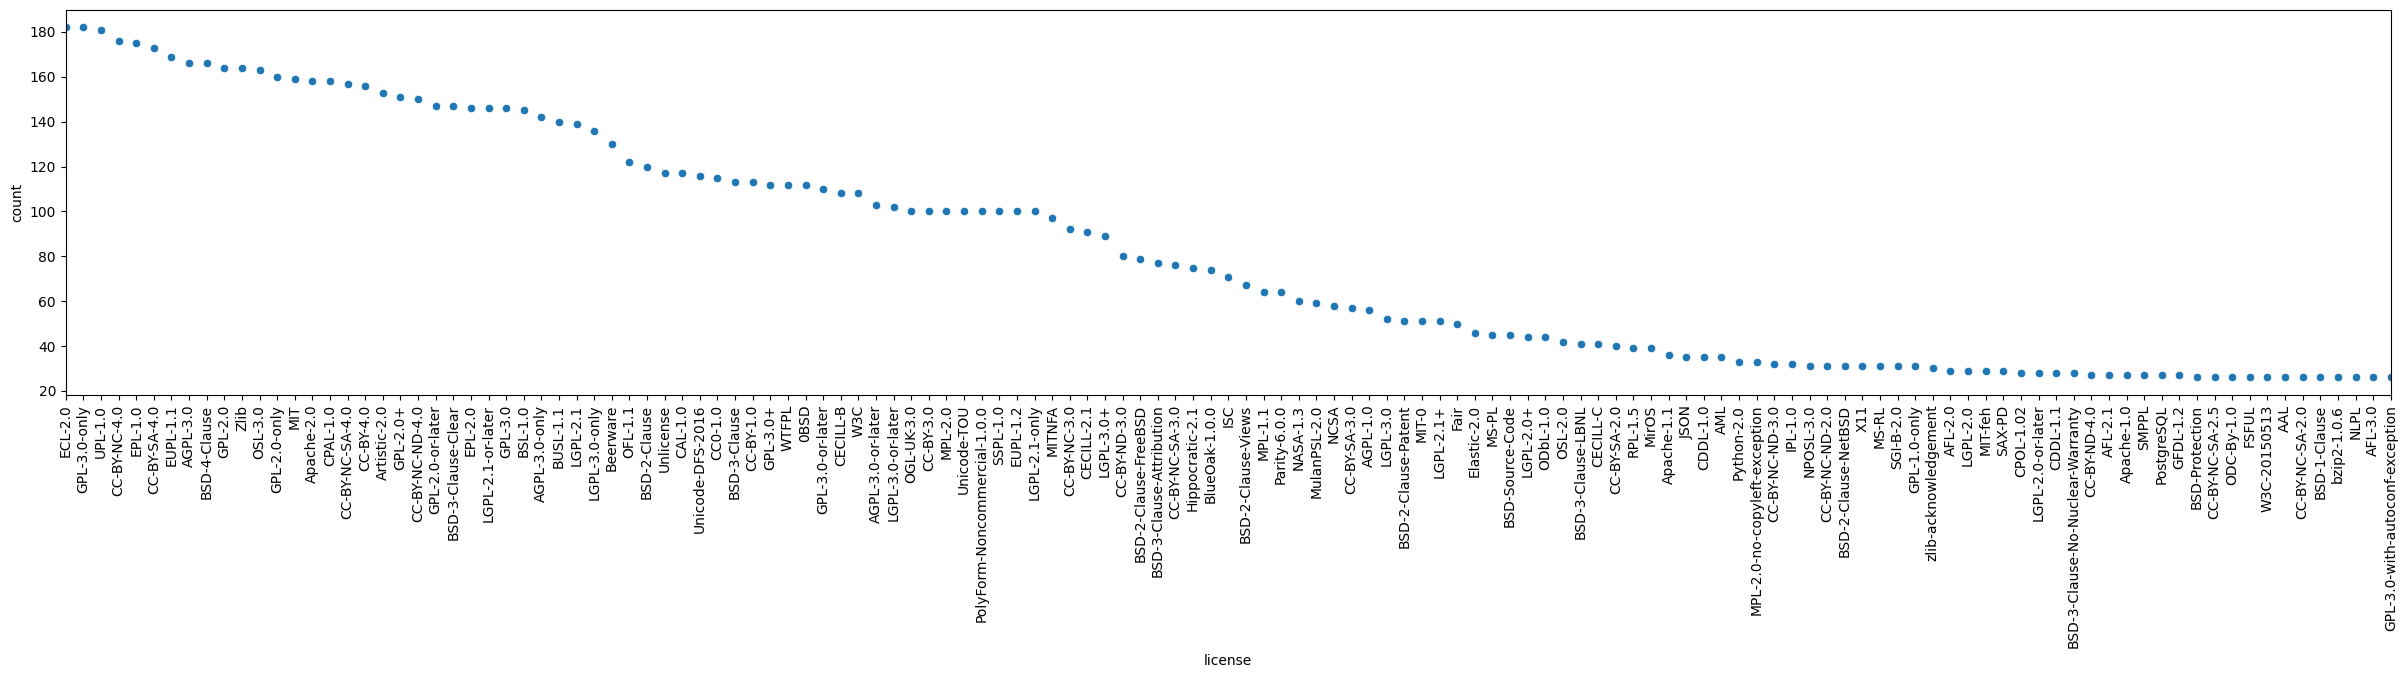

In [ ]:
plt.figure(figsize=(30,5))
plt.xlim(0, 132)
plt.xticks(rotation=90)

sns.scatterplot(
    data=license_df,
    x="license", y="count",
)

### Add a new column `text_length` to view the distribution of liense text length

In [ ]:
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
df.head()

,text,license,word_count
0,attribution-noncommercial-noderivs 2.0 copyrig...,CC-BY-NC-ND-2.0,1911
1,attribution-noncommercial-noderivs 2.0 copyrig...,CC-BY-NC-ND-2.0,1911
2,attribution-noncommercial-noderivs 2.0 copyrig...,CC-BY-NC-ND-2.0,1911
3,attribution-noncommercial-noderivs 2.0 copyrig...,CC-BY-NC-ND-2.0,1911
4,attribution-noncommercial-noderivs 2.0 copyrig...,CC-BY-NC-ND-2.0,1911


In [ ]:
plt.figure(figsize=(20, 5))

sns.displot(df['word_count'], kde=True, bins=50)

plt.xlim(0, 10000)

plt.xlabel('Word Count')
plt.ylabel('Samples')
plt.title('Distribution of word count per license text')
plt.show()

NameError: name 'plt' is not defined

### Investigating outliers

In [91]:
large_df = df[df['word_count'] > 7000]
large_df.head()

,text,license,word_count


## Prepare the train, test, and validation datasets

### Get a unique list of licenses

In [92]:
unique_license_list = license_df.license.unique().tolist()

print(unique_license_list)
print(len(unique_license_list))

['ECL-2.0', 'GPL-3.0-only', 'UPL-1.0', 'CC-BY-NC-4.0', 'EPL-1.0', 'CC-BY-SA-4.0', 'EUPL-1.1', 'AGPL-3.0', 'BSD-4-Clause', 'GPL-2.0', 'Zlib', 'OSL-3.0', 'GPL-2.0-only', 'MIT', 'Apache-2.0', 'CPAL-1.0', 'CC-BY-NC-SA-4.0', 'CC-BY-4.0', 'Artistic-2.0', 'GPL-2.0+', 'CC-BY-NC-ND-4.0', 'GPL-2.0-or-later', 'BSD-3-Clause-Clear', 'EPL-2.0', 'LGPL-2.1-or-later', 'GPL-3.0', 'BSL-1.0', 'AGPL-3.0-only', 'BUSL-1.1', 'LGPL-2.1', 'LGPL-3.0-only', 'Beerware', 'OFL-1.1', 'BSD-2-Clause', 'Unlicense', 'CAL-1.0', 'Unicode-DFS-2016', 'CC0-1.0', 'BSD-3-Clause', 'CC-BY-1.0', 'GPL-3.0+', 'WTFPL', '0BSD', 'GPL-3.0-or-later', 'CECILL-B', 'W3C', 'AGPL-3.0-or-later', 'LGPL-3.0-or-later', 'OGL-UK-3.0', 'CC-BY-3.0', 'MPL-2.0', 'Unicode-TOU', 'PolyForm-Noncommercial-1.0.0', 'SSPL-1.0', 'EUPL-1.2', 'LGPL-2.1-only', 'MITNFA', 'CC-BY-NC-3.0', 'CECILL-2.1', 'LGPL-3.0+', 'CC-BY-ND-3.0', 'BSD-2-Clause-FreeBSD', 'BSD-3-Clause-Attribution', 'CC-BY-NC-SA-3.0', 'Hippocratic-2.1', 'BlueOak-1.0.0', 'ISC', 'BSD-2-Clause-Views', 'M

### Create the license label mappings

In [93]:
id2Label = {str(i): label for i, label in enumerate(unique_license_list)}
label2id = {label: i for i, label in enumerate(unique_license_list)}

In [94]:
id2Label


{'0': 'ECL-2.0',
 '1': 'GPL-3.0-only',
 '2': 'UPL-1.0',
 '3': 'CC-BY-NC-4.0',
 '4': 'EPL-1.0',
 '5': 'CC-BY-SA-4.0',
 '6': 'EUPL-1.1',
 '7': 'AGPL-3.0',
 '8': 'BSD-4-Clause',
 '9': 'GPL-2.0',
 '10': 'Zlib',
 '11': 'OSL-3.0',
 '12': 'GPL-2.0-only',
 '13': 'MIT',
 '14': 'Apache-2.0',
 '15': 'CPAL-1.0',
 '16': 'CC-BY-NC-SA-4.0',
 '17': 'CC-BY-4.0',
 '18': 'Artistic-2.0',
 '19': 'GPL-2.0+',
 '20': 'CC-BY-NC-ND-4.0',
 '21': 'GPL-2.0-or-later',
 '22': 'BSD-3-Clause-Clear',
 '23': 'EPL-2.0',
 '24': 'LGPL-2.1-or-later',
 '25': 'GPL-3.0',
 '26': 'BSL-1.0',
 '27': 'AGPL-3.0-only',
 '28': 'BUSL-1.1',
 '29': 'LGPL-2.1',
 '30': 'LGPL-3.0-only',
 '31': 'Beerware',
 '32': 'OFL-1.1',
 '33': 'BSD-2-Clause',
 '34': 'Unlicense',
 '35': 'CAL-1.0',
 '36': 'Unicode-DFS-2016',
 '37': 'CC0-1.0',
 '38': 'BSD-3-Clause',
 '39': 'CC-BY-1.0',
 '40': 'GPL-3.0+',
 '41': 'WTFPL',
 '42': '0BSD',
 '43': 'GPL-3.0-or-later',
 '44': 'CECILL-B',
 '45': 'W3C',
 '46': 'AGPL-3.0-or-later',
 '47': 'LGPL-3.0-or-later',
 '48': '

In [95]:
label2id

{'ECL-2.0': 0,
 'GPL-3.0-only': 1,
 'UPL-1.0': 2,
 'CC-BY-NC-4.0': 3,
 'EPL-1.0': 4,
 'CC-BY-SA-4.0': 5,
 'EUPL-1.1': 6,
 'AGPL-3.0': 7,
 'BSD-4-Clause': 8,
 'GPL-2.0': 9,
 'Zlib': 10,
 'OSL-3.0': 11,
 'GPL-2.0-only': 12,
 'MIT': 13,
 'Apache-2.0': 14,
 'CPAL-1.0': 15,
 'CC-BY-NC-SA-4.0': 16,
 'CC-BY-4.0': 17,
 'Artistic-2.0': 18,
 'GPL-2.0+': 19,
 'CC-BY-NC-ND-4.0': 20,
 'GPL-2.0-or-later': 21,
 'BSD-3-Clause-Clear': 22,
 'EPL-2.0': 23,
 'LGPL-2.1-or-later': 24,
 'GPL-3.0': 25,
 'BSL-1.0': 26,
 'AGPL-3.0-only': 27,
 'BUSL-1.1': 28,
 'LGPL-2.1': 29,
 'LGPL-3.0-only': 30,
 'Beerware': 31,
 'OFL-1.1': 32,
 'BSD-2-Clause': 33,
 'Unlicense': 34,
 'CAL-1.0': 35,
 'Unicode-DFS-2016': 36,
 'CC0-1.0': 37,
 'BSD-3-Clause': 38,
 'CC-BY-1.0': 39,
 'GPL-3.0+': 40,
 'WTFPL': 41,
 '0BSD': 42,
 'GPL-3.0-or-later': 43,
 'CECILL-B': 44,
 'W3C': 45,
 'AGPL-3.0-or-later': 46,
 'LGPL-3.0-or-later': 47,
 'OGL-UK-3.0': 48,
 'CC-BY-3.0': 49,
 'MPL-2.0': 50,
 'Unicode-TOU': 51,
 'PolyForm-Noncommercial-1.0.0'

### Add the license labels to a new column in the dataset

In [96]:
df["license_id"] = df.license.apply(lambda x: label2id[x])
df

,text,license,word_count,license_id
0,attribution-noncommercial-noderivs 2.0 copyrig...,CC-BY-NC-ND-2.0,1911,100
1,attribution-noncommercial-noderivs 2.0 copyrig...,CC-BY-NC-ND-2.0,1911,100
2,attribution-noncommercial-noderivs 2.0 copyrig...,CC-BY-NC-ND-2.0,1911,100
3,attribution-noncommercial-noderivs 2.0 copyrig...,CC-BY-NC-ND-2.0,1911,100
4,attribution-noncommercial-noderivs 2.0 copyrig...,CC-BY-NC-ND-2.0,1911,100
...,...,...,...,...
11213,apple public source license\nversion 2.0 - au...,APSL-2.0,3185,133
11214,apple public source license\nversion 2.0 - au...,APSL-2.0,3185,133
11215,apple public source license\nversion 2.0 - au...,APSL-2.0,3185,133
11216,apple public source license\nversion 2.0 - au...,APSL-2.0,3185,133


### Create the training, testing, and validation data splits

In [97]:
df['license_id'] = df['license_id'].astype('int')

dataset = Dataset.from_pandas(df)
dataset = DatasetDict({
    "train": dataset,
    "test": dataset,
    "validate": dataset
})
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'license', 'word_count', 'license_id', '__index_level_0__'],
        num_rows: 10980
    })
    test: Dataset({
        features: ['text', 'license', 'word_count', 'license_id', '__index_level_0__'],
        num_rows: 10980
    })
    validate: Dataset({
        features: ['text', 'license', 'word_count', 'license_id', '__index_level_0__'],
        num_rows: 10980
    })
})

### Remove colum not needed

In [98]:
dataset["train"] = dataset["train"].remove_columns(["__index_level_0__"])
dataset["test"] = dataset["test"].remove_columns(["__index_level_0__"])
dataset["validate"] = dataset["validate"].remove_columns(["__index_level_0__"])
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'license', 'word_count', 'license_id'],
        num_rows: 10980
    })
    test: Dataset({
        features: ['text', 'license', 'word_count', 'license_id'],
        num_rows: 10980
    })
    validate: Dataset({
        features: ['text', 'license', 'word_count', 'license_id'],
        num_rows: 10980
    })
})

### Deduplicate the testing and validation datasets

In [99]:
print("Deduplicating the TEST datsset")

test_df = dataset['test'].to_pandas()
print(f"Before: {test_df.shape}")

test_df = test_df.drop_duplicates()
print(f"After: {test_df.shape}")


Deduplicating the TEST datsset
Before: (10980, 4)
After: (822, 4)


In [100]:
print("Deduplicating the VALIDATION datsset")

validate_df = dataset['validate'].to_pandas()

print(f"Before: {validate_df.shape}")

validate_df = validate_df.drop_duplicates()
print(f"After: {validate_df.shape}")

Deduplicating the VALIDATION datsset
Before: (10980, 4)
After: (822, 4)


<Axes: xlabel='license', ylabel='count'>

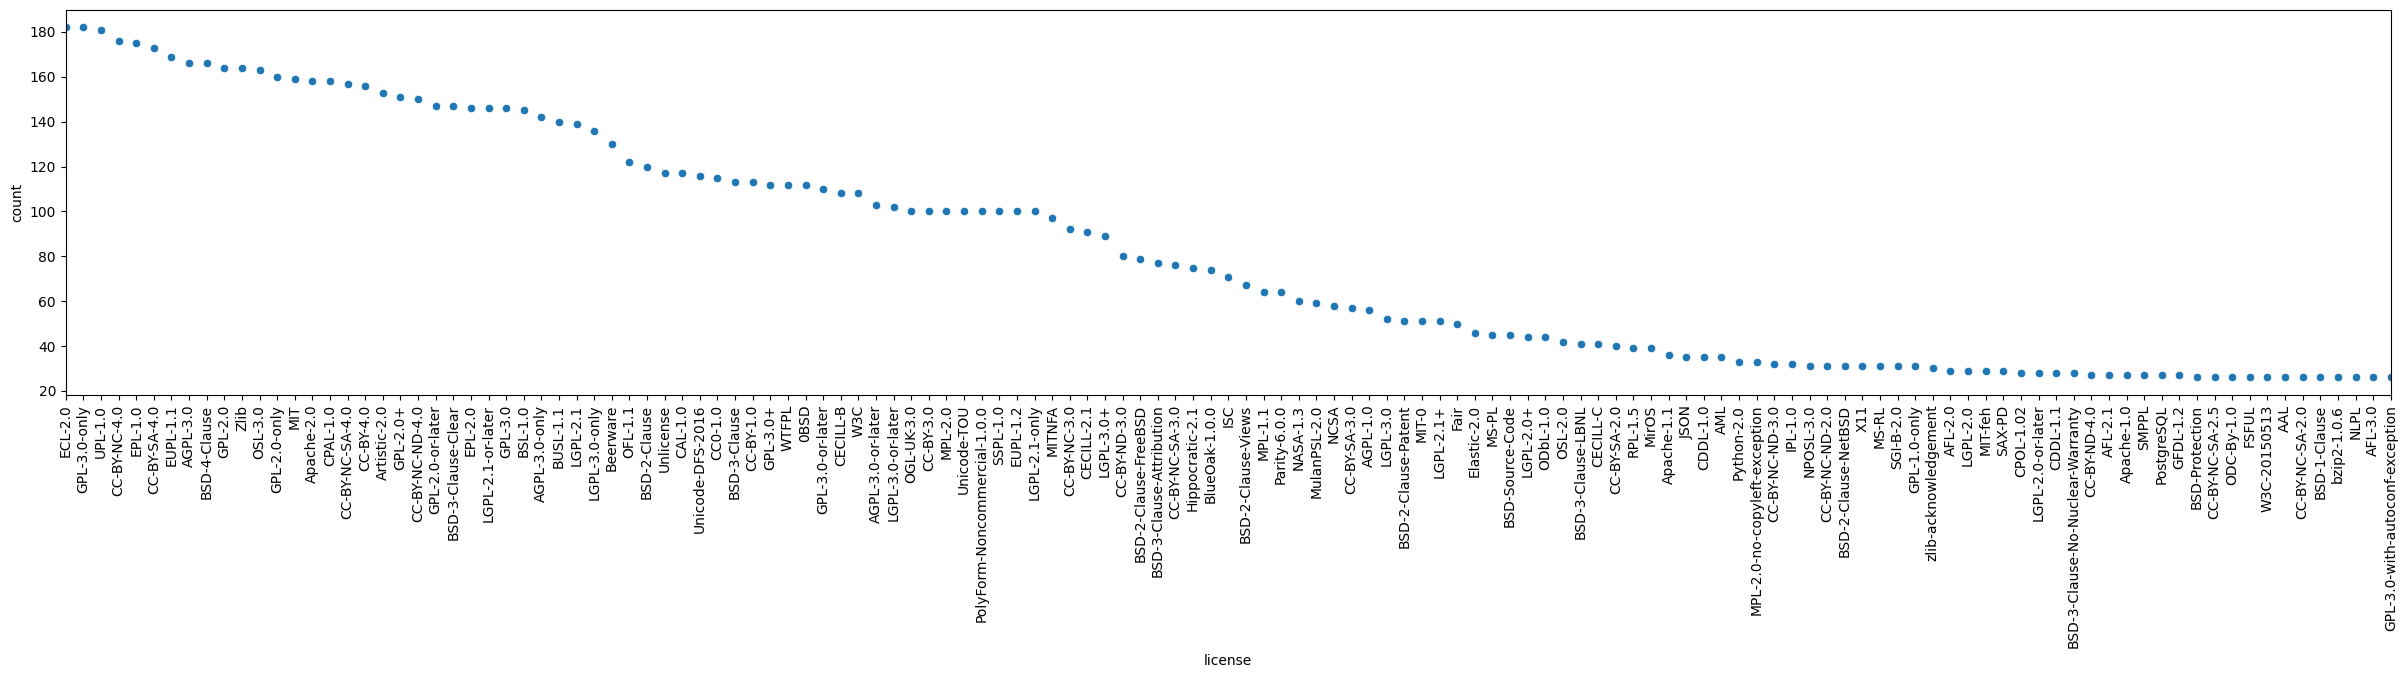

In [101]:
train_df = dataset['train'].to_pandas()
train_license_df = train_df['license'].value_counts().to_frame('count').rename_axis('license').reset_index()
train_license_df

plt.figure(figsize=(30,5))
plt.xlim(0, 132)
plt.xticks(rotation=90)

sns.scatterplot(
    data=train_license_df,
    x="license", y="count",
)

<Axes: xlabel='license', ylabel='count'>

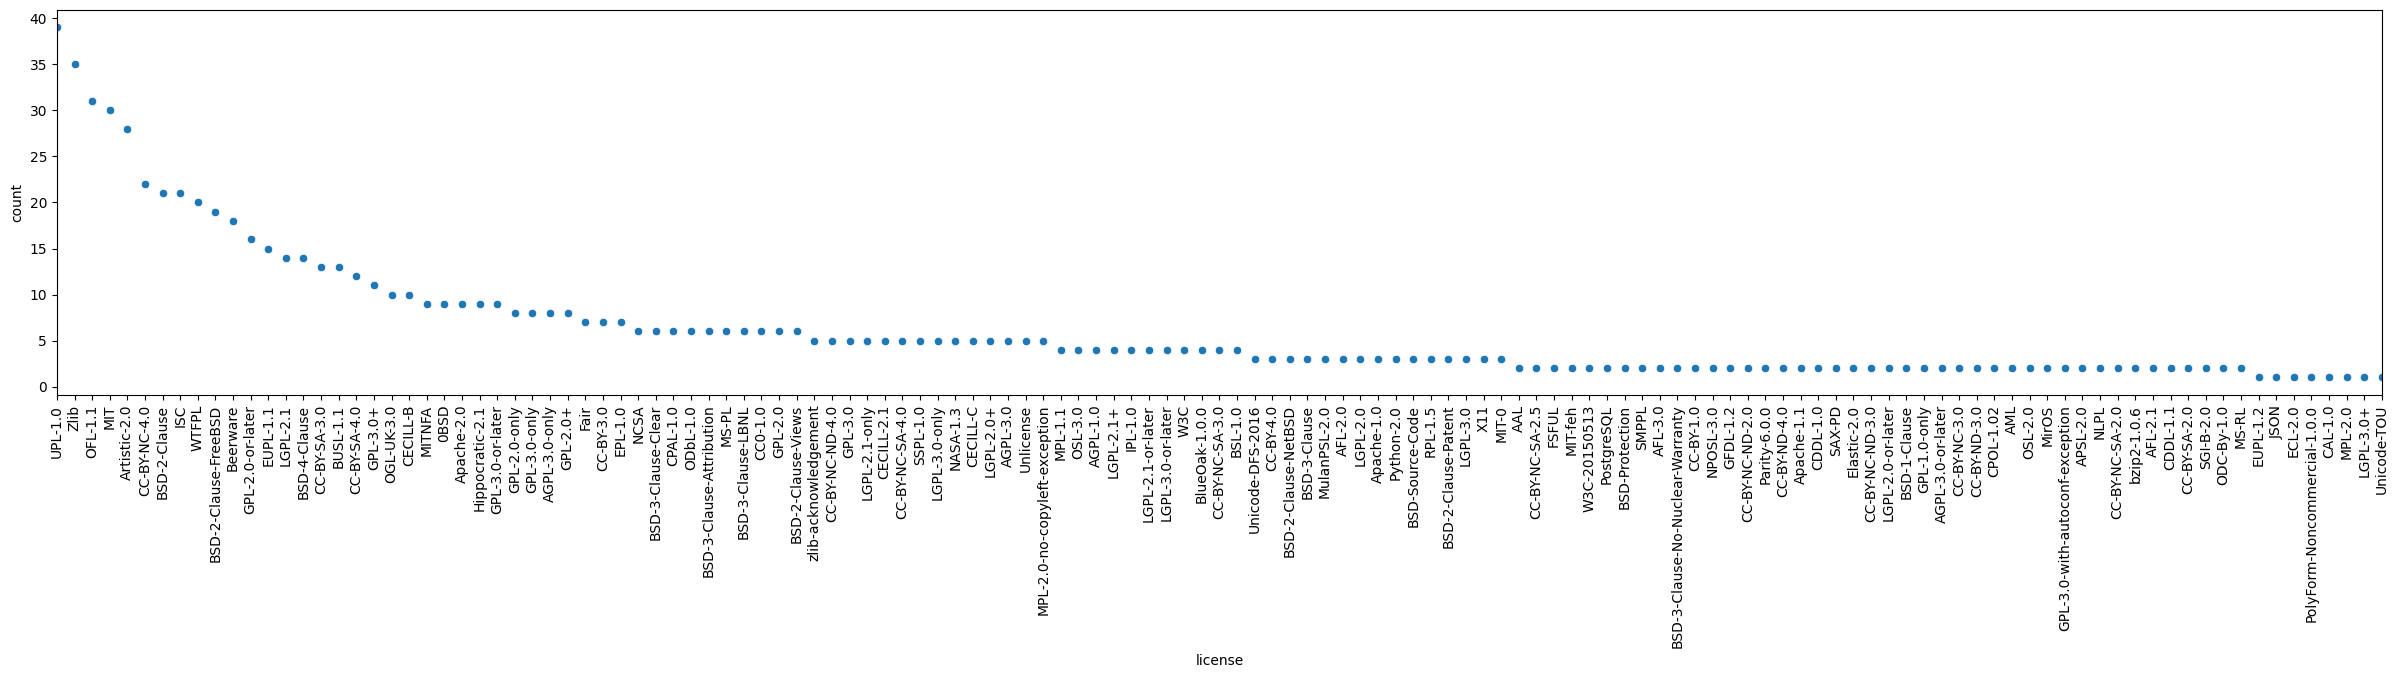

In [102]:
test_license_df = test_df['license'].value_counts().to_frame('count').rename_axis('license').reset_index()
test_license_df

plt.figure(figsize=(30,5))
plt.xlim(0, 132)
plt.xticks(rotation=90)

sns.scatterplot(
    data=test_license_df,
    x="license", y="count",
)

## Transform the datasets for training

### Define the checkpoint. Create the tokenizer & model

In [103]:
# BERT BASE - 512 max embeddings
# checkpoint = "bert-base-uncased"
# model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=len(unique_license_list))
# tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# 3rd Party - 1024 max embeddings
checkpoint = "Sreevishnu/funnel-transformer-small-imdb"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=len(unique_license_list), ignore_mismatched_sizes=True, max_position_embeddings=1024)
tokenizer = AutoTokenizer.from_pretrained(checkpoint, use_fast=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Some weights of FunnelForSequenceClassification were not initialized from the model checkpoint at Sreevishnu/funnel-transformer-small-imdb and are newly initialized because the shapes did not match:
- classifier.linear_out.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([134, 768]) in the model instantiated
- classifier.linear_out.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([134]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Create the tokenize function

In [104]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, return_tensors="pt")

### Tokenize the dataset and remove unnecessary columns

In [105]:
tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=["text", "license", "word_count"])
tokenized_datasets = tokenized_datasets.rename_column("license_id", "labels")

Map:   0%|          | 0/10980 [00:00<?, ? examples/s]

### Define training arguments

In [106]:
training_args = TrainingArguments(
    output_dir="model_output",
    num_train_epochs=9,
    evaluation_strategy="epoch",
)

### Define matrics function

In [107]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

### Create the trainer

In [108]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validate"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

## Train the model!

In [109]:
trainer.train()

/home/mpcen/workspace/projects/web2/1es-hackathon/ai-model/.venv/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a FunnelTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,2.047600,0.970055,0.739344
2,0.617300,0.480825,0.819763
3,0.437400,0.418968,0.829053
4,0.431900,0.366862,0.847177
5,0.365300,0.341040,0.842805
6,0.342900,0.329704,0.856922
7,0.317300,0.310343,0.858288
8,0.315000,0.296309,0.868670


TrainOutput(global_step=10984, training_loss=0.6821037036870746, metrics={'train_runtime': 4176.3395, 'train_samples_per_second': 21.033, 'train_steps_per_second': 2.63, 'total_flos': 2.50589430300672e+16, 'train_loss': 0.6821037036870746, 'epoch': 8.0})

### Save the newly trained model and tokenizer

In [110]:
save_dir = "./saved_model"

model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json',
 './saved_model/tokenizer.json')

## Using the newly trained model and tokenizer

### Define the new model and tokenizer

In [111]:
legal_tokenizer = AutoTokenizer.from_pretrained(save_dir)
legal_model = AutoModelForSequenceClassification.from_pretrained(save_dir)

### Test the new model & tokenizer

In [112]:
import torch

license_text = """
Boost Software License - Version 1.0 - August 17th, 2003

Permission is hereby granted, free of charge, to any person or organization
obtaining a copy of the software and accompanying documentation covered by
this license (the "Software") to use, reproduce, display, distribute,
execute, and transmit the Software, and to prepare derivative works of the
Software, and to permit third-parties to whom the Software is furnished to
do so, all subject to the following:

The copyright notices in the Software and this entire statement, including
the above license grant, this restriction and the following disclaimer,
must be included in all copies of the Software, in whole or in part, and
all derivative works of the Software, unless such copies or derivative
works are solely in the form of machine-executable object code generated by
a source language processor.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE, TITLE AND NON-INFRINGEMENT. IN NO EVENT
SHALL THE COPYRIGHT HOLDERS OR ANYONE DISTRIBUTING THE SOFTWARE BE LIABLE
FOR ANY DAMAGES OR OTHER LIABILITY, WHETHER IN CONTRACT, TORT OR OTHERWISE,
ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
DEALINGS IN THE SOFTWARE.
"""

def test_license(license_text):
    tokenized_input = legal_tokenizer(license_text, truncation=True, padding=True, return_tensors="pt")
    output = legal_model(**tokenized_input)
    prediction_value = torch.argmax(output.logits).item()
    result = id2Label[str(prediction_value)]
    return result

test_license(license_text)

'BSL-1.0'